# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Trajectory-clustering-with-traj" data-toc-modified-id="Trajectory-clustering-with-traj-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Trajectory clustering with traj</a></div>

# Trajectory clustering with traj

Example of clustering time trajectories / time series with traj

traj vignette: https://cran.r-project.org/web/packages/traj/vignettes/trajVignette.pdf

In [126]:
library(tidyverse, quietly=T)
library(caret)
library(traj)
options(jupyter.plot_mimetypes = 'image/png')
mousephen = read.csv("datasets/mousephenotype/mousephenotypedata.csv") %>% 
    tbl_df %>%
    mutate(gene = paste0("gene", gene)
          #animal = paste0("animal", animal)
          )


mousephen %>% head

animal,gene,sex,zygosity,week,weight
116489494,gene143,1,0,4.000000,17.0
116489494,gene143,1,0,5.000000,20.2
116489494,gene143,1,0,6.000000,22.1
116489494,gene143,1,0,7.000000,25.2
116489494,gene143,1,0,7.428571,25.4
116489494,gene143,1,0,9.000000,26.4


Reading and plotting the data.


     animal              gene                sex            zygosity     
 Min.   : 37448824   Length:2849        Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 91998068   Class :character   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :116489502   Mode  :character   Median :1.0000   Median :1.0000  
 Mean   :110928012                      Mean   :0.5216   Mean   :0.6153  
 3rd Qu.:130783034                      3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :153843557                      Max.   :1.0000   Max.   :2.0000  
      week            weight     
 Min.   : 2.857   Min.   : 5.00  
 1st Qu.: 7.857   1st Qu.:19.37  
 Median :11.000   Median :22.54  
 Mean   :10.816   Mean   :22.72  
 3rd Qu.:14.000   3rd Qu.:26.20  
 Max.   :18.857   Max.   :37.80  

animal,gene,sex,zygosity,week,weight
261,17,2,3,109,1213


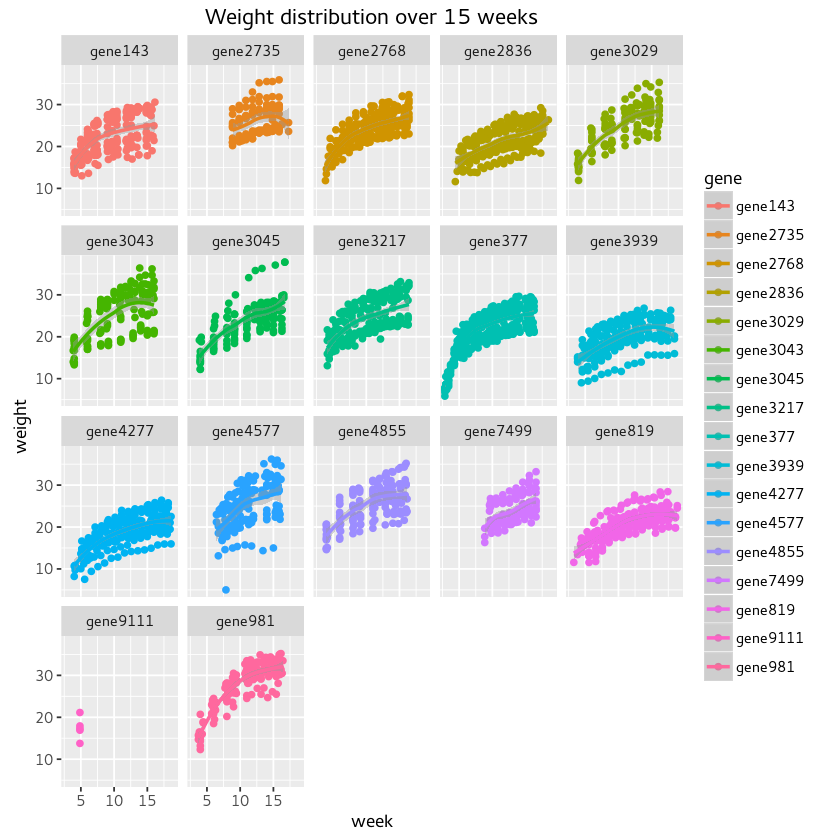

In [127]:
cat("Reading and plotting the data.\n")
mousephen %>% summary
mousephen %>% summarise_each(funs(n_distinct(.)))

#graphics::plot(mousephen$x,  mousephen$y)
p = mousephen %>% ggplot(aes(x=week, y=weight, color=gene)) + 
    geom_point() +
    facet_wrap(~gene) + 
    geom_smooth() +
    ggtitle("Weight distribution over 15 weeks") 
print(p)

In [159]:
cat("Preparing data for trajectory clustering. We need two matrixes, one with the time measurements, and one with the weights\n")

mousephen = mousephen %>% 
    group_by(animal) %>% 
    arrange(animal, week) %>% 
    mutate(measurementId = row_number()) %>% 
    mutate(days=week*7) %>%     
    filter(days>28) %>% # simplifying data
    ungroup 

mousephen.times = mousephen %>% 
    select(animal, measurementId, days) %>% 
    spread(measurementId, days) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
mousephen.values = mousephen %>% 
    select(animal, measurementId, weight) %>%  
    spread(measurementId, weight) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

cat("\nTime measurements, in days:\n")
mousephen.times %>% head
mousephen.times %>% dim
cat("Weights:\n")
mousephen.values %>% head
mousephen.values %>% dim

Preparing data for trajectory clustering. We need two matrixes, one with the time measurements, and one with the weights

Time measurements, in days:


,animal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,37448824,30,36,43,50,57,65,73,76,85,90,97,104,113,NA,NA
2,37448827,30,36,43,50,57,65,73,76,85,90,97,104,113,NA,NA
3,37448830,34,41,48,55,63,71,74,83,88,95,102,111,NA,NA,NA
4,37448833,34,41,48,55,63,71,74,83,88,95,102,111,NA,NA,NA
5,37448836,61,69,72,81,86,93,100,109,NA,NA,NA,NA,NA,NA,NA
6,37626612,30,36,43,50,57,66,73,76,85,90,97,104,114,NA,NA


[1] 260  16

Weights:


,animal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,37448824,15.94,18.60,20.20,20.63,21.88,22.68,22.39,22.16,23.18,23.39,23.29,24.88,24.59,NA,NA
2,37448827,15.61,17.36,19.39,21.26,22.46,22.31,22.63,22.59,24.11,24.31,24.58,25.95,25.13,NA,NA
3,37448830,18.16,19.50,20.90,21.59,21.95,22.82,23.65,23.75,23.85,24.48,24.71,23.56,NA,NA,NA
4,37448833,15.14,18.26,19.14,19.72,19.84,20.82,21.03,22.74,22.11,22.19,22.54,23.15,NA,NA,NA
5,37448836,22.29,22.86,23.05,24.13,23.53,24.79,25.13,24.79,NA,NA,NA,NA,NA,NA,NA
6,37626612,17.65,19.54,21.44,22.76,24.61,25.39,26.46,26.43,26.81,27.36,27.78,28.67,30.21,NA,NA


[1] 260  16

In [129]:
cat('Trajectory Clustering step 1 - calculating measures\n')
s1 = step1measures(mousephen.values, mousephen.times, ID=TRUE)
head(s1$measurments)  %>% print.data.frame


Trajectory Clustering step 1 - calculating measures
[1] "Correlation of m11 and m15 : 1"
        ID    m1       m2       m3        m4    m5         m6        m7
1 37448824  8.94 21.83154 2.477855 11.349886  8.65 0.10297619 0.5426600
2 37448827 10.34 22.13000 3.060479 13.829549  9.52 0.11333333 0.6098655
3 37448830  6.55 22.41000 2.048658  9.141714  5.40 0.06923077 0.2973568
4 37448833  8.01 20.55667 2.308787 11.231329  8.01 0.10269231 0.5290621
5 37448836  2.84 23.82125 1.044269  4.383772  2.50 0.05102041 0.1121579
6 37626612 12.56 25.00846 3.687729 14.745926 12.56 0.14776471 0.7116147
         m8         m9       m10  m11       m12        m13       m14  m15
1 0.3962158 0.08557814 0.8426032 2.66 0.9357297 0.14832213 0.8725000 2.66
2 0.4301853 0.10755985 0.8725103 2.03 0.9374466 0.13194977 0.9616667 2.03
3 0.2409639 0.07591595 0.8342582 1.40 0.7034551 0.11014853 0.7000000 1.40
4 0.3896546 0.08670815 0.8568908 3.12 0.9926411 0.14123729 0.8427273 3.12
5 0.1049483 0.05940666 0.8658768 1.26

In [158]:

cat('Trajectory Clustering step 2 - calculating factors\n')
s2= step2factors(s1)
#s2
cat('ok')

Trajectory Clustering step 2 - calculating factors
[1] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."
ok

In [134]:
cat('Calculating clusters\n')
s3 = step3clusters(s2, nclusters = 4)
cat('ok\n')

Calculating clusters


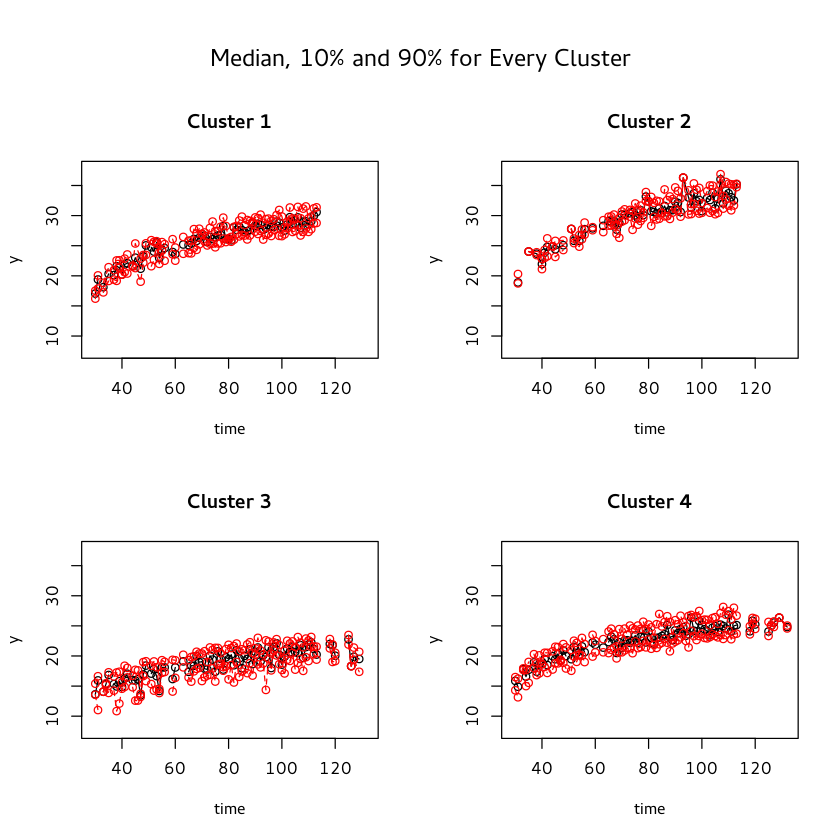

In [135]:
plotMedTraj(s3)

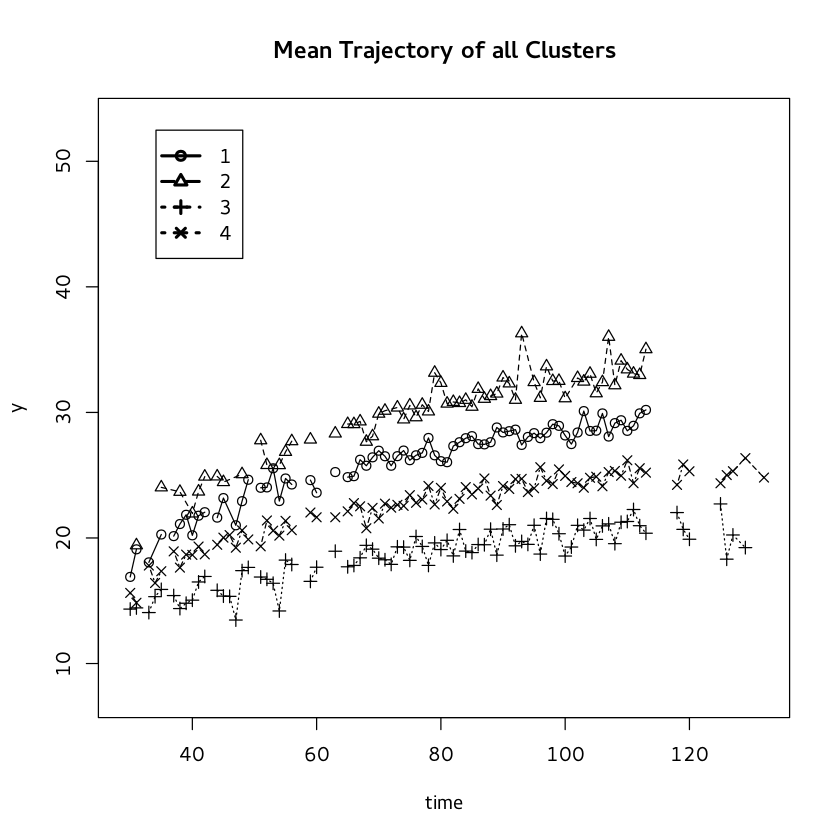

In [136]:
plotCombTraj(s3)

automatically calculating optimal number of cluster

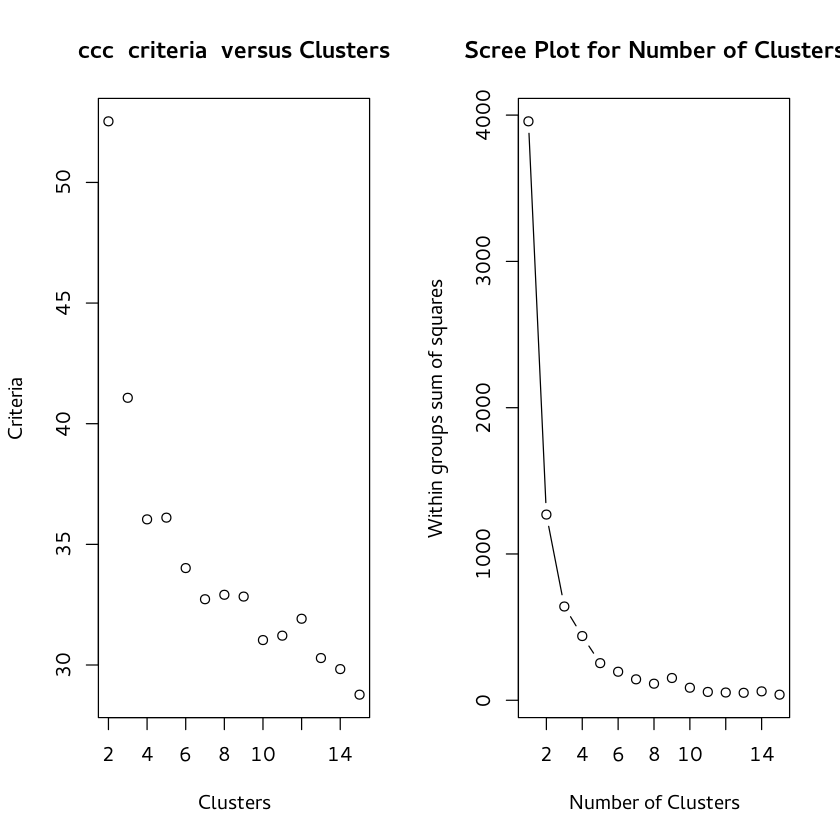

In [139]:
cat('automatically calculating optimal number of cluster')
s3.auto = step3clusters(s2)


  1   2 
 95 157 

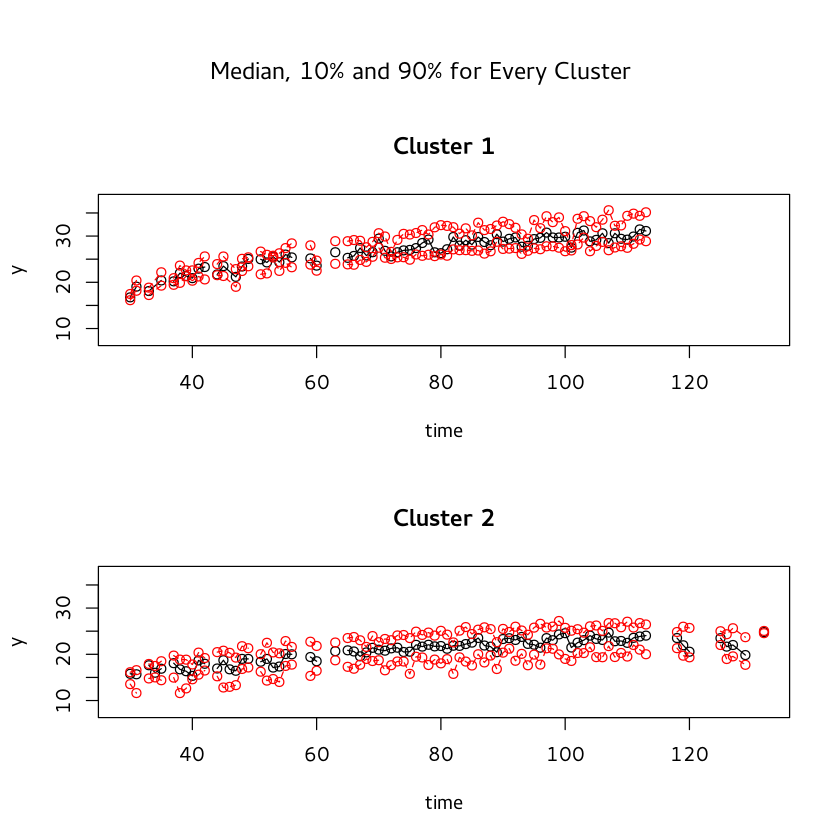

In [138]:
s3.auto$clust.distr
plotMedTraj(s3.auto)

Characterization of clusters

The high growth class has an higher percentage of males. A regression may improve the prediction

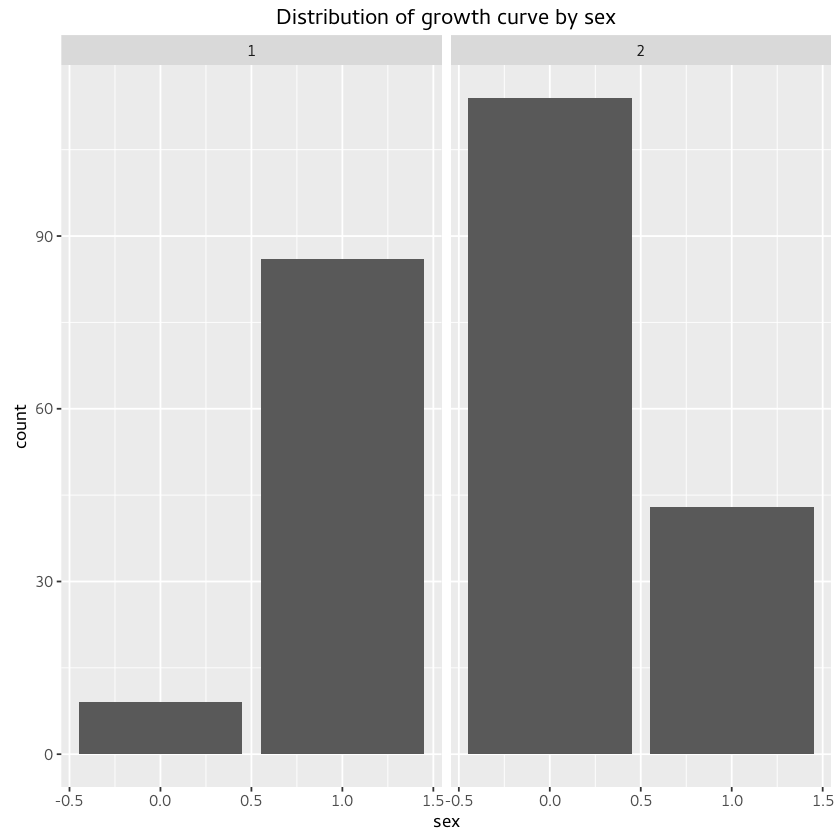

In [160]:
cat('Characterization of clusters')
#head(s3.auto$clusters)

mousephen.cl = mousephen %>% left_join(s3.auto$clusters %>% rename(animal=ID), by='animal')
#mousephen.cl %>% head

mousephen.cl %>% select(animal, sex, zygosity, cluster) %>%
    distinct %>%
    filter(!is.na(cluster)) %>%
    ggplot(aes(x=sex, fill=sex)) +
        facet_wrap(~cluster) +
        geom_bar() + 
        ggtitle("Distribution of growth curve by sex")
cat('The high growth class has an higher percentage of males. A regression may improve the prediction')

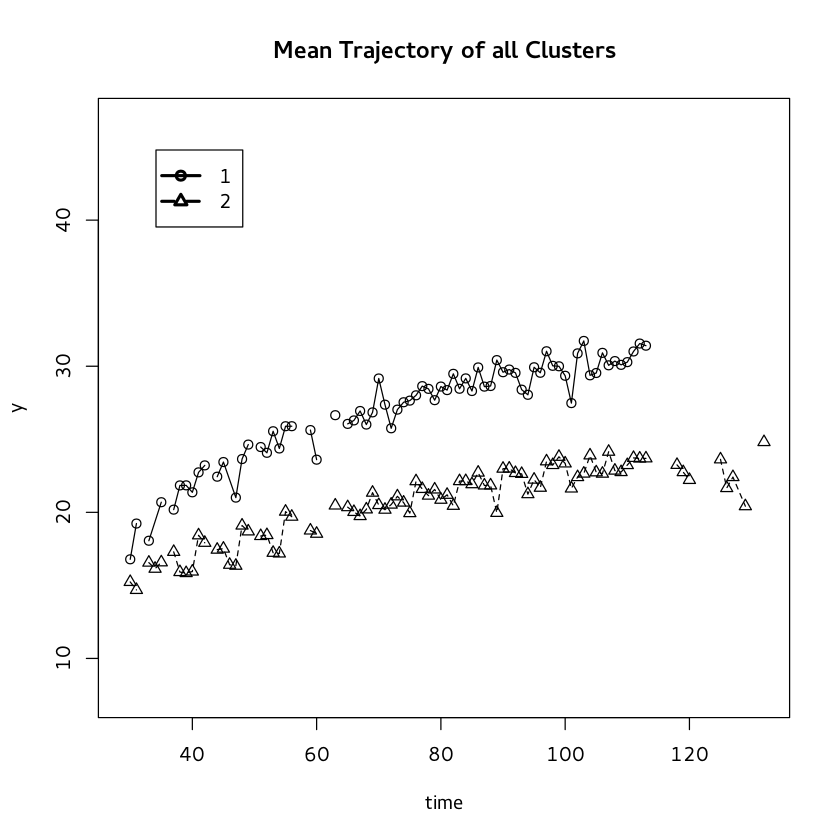

In [153]:
plotCombTraj(s3.auto)